# ec-land ML training database

We have run offline simulations with the ec-land land surface model forced by ERA5 atmospheric fields. These land surface model outputs have then been converted to `zarr` format for easy and fast read access during ML training.

In the cells below we briefly explore the database to show what is included and produce some spatial/temporal plots for difference variables. We use the `xarray` package to easily open up and explore the data here, but in the training we use the base `zarr` python package to make for even quicker read-access to the data (`xarray` includes lots of useful functions and pacakges that can slow down training but are great for exploring the data!).

In [1]:
# Python imports
import numpy as np
import xarray as xr

## Opening the database and inspecting the variables

Below we open the database and look a the meta-data by printing out the `xarray` representation on the database. The main forcing and model output data is contained under the `data` Data variable which has dimensions (`time`, `x`, `variable`), where `x` is our spatial dimension using the ECMWF triangular–
cubic-octahedral (TCo) grid.

Under `variable` we can see we have different types of model variables, anything prefaced with `met_` is part of the meteorological atmospheric forcing of the model (leaf area index low and high (`lai_lv` & `lai_hv`) are also treated as forcings by the model), then we have model output variables:
* `d2m` - 2m dewpoint temperature
* `dis` - river discharge
* `e` - evaporation
* `rsn` - snow density
* `sd` - snow depth
* `skt` - skin temperature
* `snowc` - fractional snow cover of grid point
* `sro`, `ssro` - surface and subsurface gridcell runoff
* `stl1`, `stl2`, `stl3` - soil temperature for the top 3 layers
* `swvl1`, `swvl2`, `swvl3` - soil moisture for top 3 layers
* `t2m` - 2m temperature
* `tsn` - snow temperature
* `sshf` - surface sensible heat flux
* `slhf` - surface latent heat flux
* `es` - snow evaporation

We also have some time-invariant "climatological" features that are used by the ec-land model under the `clim_data` with dimensions (`x`, `clim_variable`). Here we have variables:
* `clim_cell_area` - grid cell area
* `clim_geopot` - geopotential height of gridcell
* `clim_cvl`, `clim_cvh` - low/high vegetation cover fraction of gridcell
* `clim_tvl`, `clim_tvh` - low/high vegetation type at gridcell
* `clim_leandsea` - land/sea fraction (0 - 1)
* `clim_sotype` - soil type
* `clim_sdor` - standard deviation of orography
* `clim_sdfor` - standard deviation of filtered orography
* `clim_ldepth` - lake depth
* `clim_clake` - lake cover fraction
* `clim_cu` - urban cover fraction
* `clim_ctype` - C3/C4 carbon assimilation pathway type
* `clim_glm` - glacier land mask
* `clim_theta_pwp` - partial wilting point of soil
* `clim_theta_cap` - field capacity of soil
* `clim_veg_rsminl`, `clim_veg_rsminh` - rsmin parameter of vegetation
* `clim_veg_covl`, `clim_veg_covh` - average veg cover 
* `clim_veg_z0ml`, `clim_veg_z0mh` - roughness length of low/high vegetation

In [4]:
train_ds = xr.open_zarr("/ec/res4/hpcperm/daep/ec_land_training_db/ecland_i8ki_2010_2022_6h.zarr")
train_ds

<xarray.Dataset>
Dimensions:                     (x: 47892, clim_variable: 22, time: 18868,
                                 variable: 33)
Coordinates:
  * clim_variable               (clim_variable) object 'clim_cell_area' ... '...
    lat                         (x) float32 dask.array<chunksize=(47892,), meta=np.ndarray>
    lon                         (x) float32 dask.array<chunksize=(47892,), meta=np.ndarray>
  * time                        (time) datetime64[ns] 2010-01-01 ... 2022-11-...
  * variable                    (variable) object 'met_ctpf' ... 'es'
  * x                           (x) int32 713 714 715 ... 167198 167199 167200
Data variables: (12/18)
    clim_data                   (x, clim_variable) float32 dask.array<chunksize=(47892, 22), meta=np.ndarray>
    clim_maxs                   (clim_variable) float32 dask.array<chunksize=(22,), meta=np.ndarray>
    clim_means                  (clim_variable) float32 dask.array<chunksize=(22,), meta=np.ndarray>
    clim_mins                   (clim_variable) float32 dask.array<chunksize=(22,), meta=np.ndarray>
    clim_stdevs                 (clim_variable) float32 dask.array<chunksize=(22,), meta=np.ndarray>
    data                        (time, x, variable) float32 dask.array<chunksize=(4, 47892, 33), meta=np.ndarray>
    ...                          ...
    global_data_1stdiff_means   (x, variable) float32 dask.array<chunksize=(47892, 33), meta=np.ndarray>
    global_data_1stdiff_stdevs  (x, variable) float32 dask.array<chunksize=(47892, 33), meta=np.ndarray>
    global_data_maxs            (x, variable) float32 dask.array<chunksize=(11973, 9), meta=np.ndarray>
    global_data_means           (x, variable) float32 dask.array<chunksize=(11973, 9), meta=np.ndarray>
    global_data_mins            (x, variable) float32 dask.array<chunksize=(11973, 9), meta=np.ndarray>
    global_data_stdevs          (x, variable) float32 dask.array<chunksize=(11973, 9), meta=np.ndarray>

## Plotting some maps

Below we use `xarray` just to plot a couple of maps for different variables.

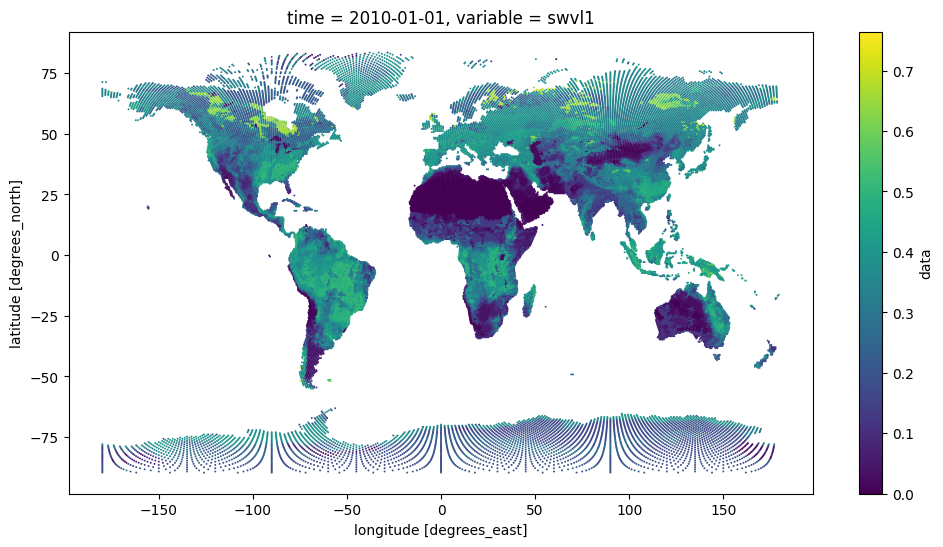

In [3]:
# Plotting soil moisture layer 1
(train_ds
 .data
 .isel(time=0)
 .sel(variable="swvl1").to_dataset()
 .plot.scatter(x="lon", y="lat", hue="data", s=2, edgecolors="none", figsize=(12,6))
)

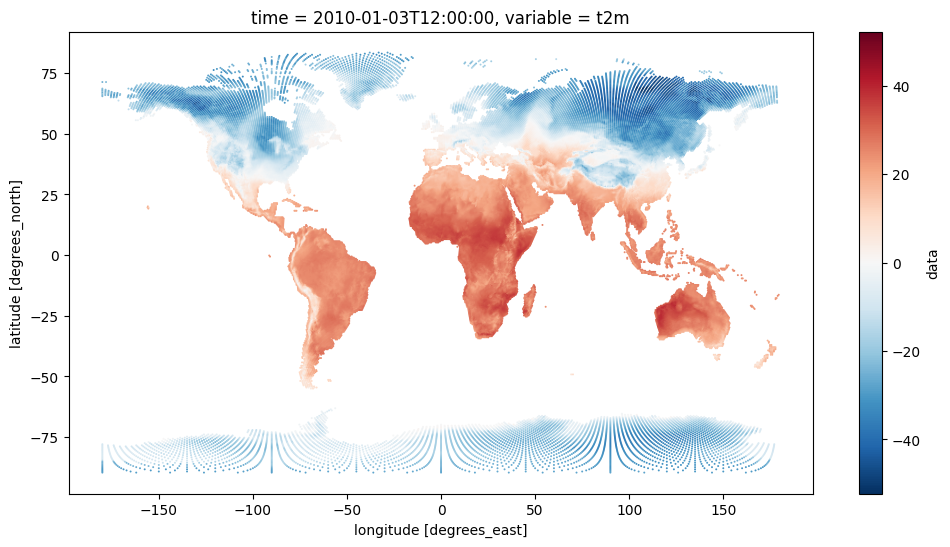

In [4]:
# Plotting 2m temperature
((train_ds
 .data
 .isel(time=10)
 .sel(variable="t2m").to_dataset() - 273)
 .plot.scatter(x="lon", y="lat", hue="data", s=2, edgecolors="none", figsize=(12,6))
)

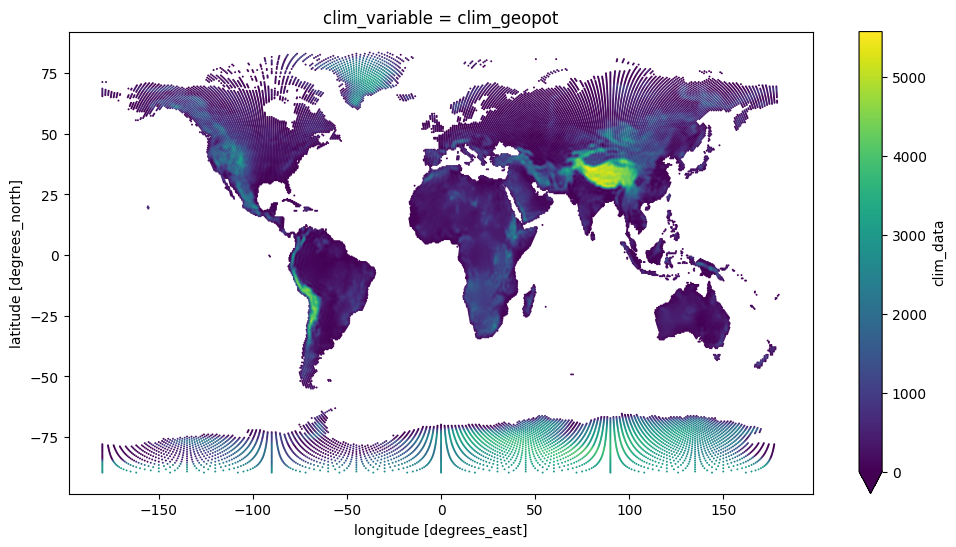

In [5]:
# Plotting orography
((train_ds
 .clim_data
 .sel(clim_variable="clim_geopot").to_dataset()/9.81)
 .plot.scatter(x="lon", y="lat", hue="clim_data", s=2, edgecolors="none", figsize=(12,6), vmin=0)
)

## Plotting some timeseries of variables

Below we plot a few timeseries of the data. We use a helper function just to get the closest `x` index to a desired lat/lon point.

In [6]:
def find_nearest_idx(
    arr1: np.ndarray,
    arr2: np.ndarray,
    val1: float,
    val2: float,
) -> int:
    """Find first nearest index for a given tolerance for two arrays and 2 values

    :param arr1: first array
    :param arr2: second arrat
    :param val1: value to find in first array
    :param val2: value to find in second array
    :return: index as int
    """
    return (np.abs(arr1 - val1) + np.abs(arr2 - val2)).argmin()

In [7]:
# Find x index for gridcell closest to desired lat/lon
lat, lon = 48.01, 5.18
x_idx = find_nearest_idx(train_ds.lat.values, train_ds.lon.values, lat, lon)

train_ds_point = (train_ds
 .data
 .isel(x=x_idx)
 .sel(time="2010").to_dataset()
).compute()

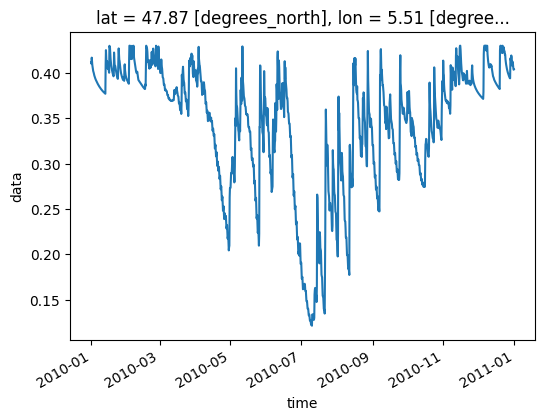

In [8]:
# Plotting soil moisture layer 1
(train_ds_point
 .data
 .sel(variable="swvl1")
 .plot(figsize=(6,4))
)

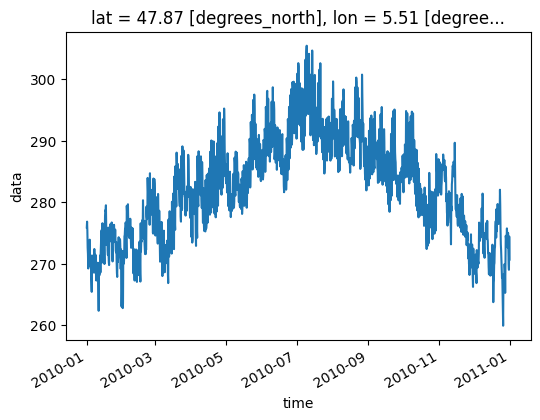

In [9]:
# Plotting 2m temperature
(train_ds_point
 .data
 .sel(variable="t2m")
 .plot(figsize=(6,4))
)

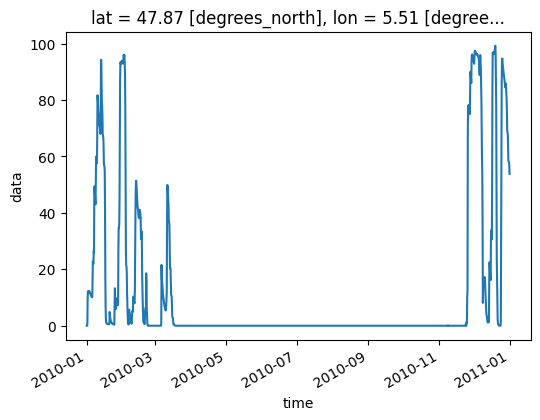

: 

In [10]:
# Plotting snow cover fraction
(train_ds_point
 .data
 .sel(variable="snowc")
 .plot(figsize=(6,4))
)